In [64]:
import polars as pl
import pandas as pd
import numpy as np
from enum import Enum
%matplotlib inline
import matplotlib.pyplot as plt
import sklearn.preprocessing as preprocessing
import keras
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate, Input,  TimeDistributed, concatenate
from keras import regularizers, optimizers
from keras.metrics import MeanAbsoluteError
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.utils import plot_model
import matplotlib.pyplot as plt

columns_to_normalize = ["close", "ema5", "ema20" , "macd520"]

def read_data(train_file = 'train_data.csv', val_file = 'val_data.csv', test_file = 'test_data.csv'):
    train_data = pl.read_csv(train_file)
    val_data = pl.read_csv(val_file)
    test_data = pl.read_csv(test_file)
    return train_data, val_data, test_data

#get data of x and y and return x and y, slice y
def extract_y(data):
    y = data['next_5_min']
    x = data.drop('next_5_min')
    return x,y


#we should not use min max scale cause the max changing over the time.
#we need to deal with two kinds of things : 1. train data - we need to create a scaler and fit it to the train, and then create a normalized data , 2. test/validation data - we should get as input the scaler of the train, and do normalize by him
def min_max_scaler(data):
    scaler = preprocessing.MinMaxScaler()
    scaled_data = scaler.fit_transform(data)
    return scaled_data, scaler

def z_score_normalize(data):
    scaler = preprocessing.StandardScaler()
    scaled_data = scaler.fit_transform(data)
    return scaled_data, scaler
    
def scale_back(data, scaler):
    return scaler.inverse_transform(data)

def normalized_x_y(x: pl.DataFrame, y: pl.DataFrame, columns_to_normalize: list):
    # Convert Polars DataFrame to NumPy array for normalization
    x_values = x.select(columns_to_normalize).to_numpy()
    y_values = y.to_numpy().reshape(-1, 1)
    # Normalize
    normalized_x_values, scaler_x = z_score_normalize(x_values)
    normalized_y_values, scaler_y = z_score_normalize(y_values)
    # Convert back to Polars DataFrame
    normalized_x = pl.DataFrame(normalized_x_values, schema=columns_to_normalize)
    normalized_y = pl.DataFrame(normalized_y_values, schema=['normalized_y'])

    return normalized_x, normalized_y, scaler_x, scaler_y

In [65]:
train_data, val_data, test_data = read_data()
x_train, y_train = extract_y(train_data)
x_val, y_val = extract_y(val_data)
x_test, y_test = extract_y(test_data)


In [66]:
# Split data to train val and test and normalize the data
x_train, y_train, x_train_scaler, y_train_scaler = normalized_x_y(x_train, y_train, columns_to_normalize)
x_val, y_val, x_val_scaler, y_val_scaler = normalized_x_y(x_val, y_val, columns_to_normalize)
x_test, y_test, x_test_scaler, y_test_scaler = normalized_x_y(x_test, y_test, columns_to_normalize)
print(x_test[:3])
print(y_test[:3])

shape: (3, 4)
┌───────────┬───────────┬───────────┬───────────┐
│ close     ┆ ema5      ┆ ema20     ┆ macd520   │
│ ---       ┆ ---       ┆ ---       ┆ ---       │
│ f64       ┆ f64       ┆ f64       ┆ f64       │
╞═══════════╪═══════════╪═══════════╪═══════════╡
│ -0.998162 ┆ -0.99737  ┆ -0.997994 ┆ 0.166266  │
│ -0.998131 ┆ -0.99739  ┆ -0.997658 ┆ 0.054219  │
│ -0.999289 ┆ -0.998367 ┆ -0.998081 ┆ -0.120579 │
└───────────┴───────────┴───────────┴───────────┘
shape: (3, 1)
┌──────────────┐
│ normalized_y │
│ ---          │
│ f64          │
╞══════════════╡
│ -0.996348    │
│ -1.000842    │
│ -0.99807     │
└──────────────┘


In [67]:
def model_creator(lstm_layer1_size, 
                  lstm_layer2_size=None, 
                  regular_layer1_size=None, 
                  regular_layer2_size=None,
                  L1=0, L2=0, 
                  dropout=0, 
                  history_points=10, 
                  data_shape=(10, 4),
                  x_train=None, y_train=None,
                  x_val=None, y_val=None,
                  batch_size=512, 
                  learning_rate=0.0005, 
                  epochs=30):
    # Building the model
    model = Sequential()

    # Adding first LSTM layer with optional regularization and dropout
    if L1:
        model.add(LSTM(lstm_layer1_size, input_shape=(history_points, data_shape[1]), 
                       kernel_regularizer=regularizers.l1(L1), activation="relu"))
    elif L2:
        model.add(LSTM(lstm_layer1_size, input_shape=(history_points, data_shape[1]), 
                       kernel_regularizer=regularizers.l2(L2), activation="relu"))
    else:
        model.add(LSTM(lstm_layer1_size, input_shape=(history_points, data_shape[1]), activation="relu"))
    
    if dropout:
        model.add(Dropout(dropout))

    # Adding second LSTM layer if specified
    if lstm_layer2_size:
        if L1:
            model.add(LSTM(lstm_layer2_size, kernel_regularizer=regularizers.l1(L1), activation="relu", return_sequences=False))
        elif L2:
            model.add(LSTM(lstm_layer2_size, kernel_regularizer=regularizers.l2(L2), activation="relu", return_sequences=False))
        else:
            model.add(LSTM(lstm_layer2_size, activation="relu", return_sequences=False))
        
        if dropout:
            model.add(Dropout(dropout))
    
    # Adding first regular Dense layer if specified
    if regular_layer1_size:
        if L1:
            model.add(Dense(regular_layer1_size, kernel_regularizer=regularizers.l1(L1), activation="relu"))
        elif L2:
            model.add(Dense(regular_layer1_size, kernel_regularizer=regularizers.l2(L2), activation="relu"))
        else:
            model.add(Dense(regular_layer1_size, activation="relu"))
        
        if dropout:
            model.add(Dropout(dropout))

    # Adding second regular Dense layer if specified
    if regular_layer2_size:
        if L1:
            model.add(Dense(regular_layer2_size, kernel_regularizer=regularizers.l1(L1), activation="relu"))
        elif L2:
            model.add(Dense(regular_layer2_size, kernel_regularizer=regularizers.l2(L2), activation="relu"))
        else:
            model.add(Dense(regular_layer2_size, activation="relu"))
        
        if dropout:
            model.add(Dropout(dropout))

    # Final output layer
    model.add(Dense(1, activation="linear"))

    # Compile the model
    adam = optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=adam, loss="mse", metrics=[MeanAbsoluteError()])

    # Training the model
    history = model.fit(x_train,
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(x_val, y_val))

    # Get validation predictions
    y_val_predicted = model.predict(x_val)
    
    # Extract metrics
    loss = history.history['loss']
    mae = history.history['mean_absolute_error']
    val_loss = history.history.get('val_loss')
    val_mae = history.history.get('val_mean_absolute_error')

    return y_val_predicted, loss, val_loss, mae, val_mae


In [77]:
def find_intersections(x, y1, y2):
    intersections = []
    for i in range(1, len(x)):
        if (y1[i-1] - y2[i-1]) * (y1[i] - y2[i]) < 0:
            # Calculate intersection point using linear interpolation
            x1, x2 = x[i-1], x[i]
            y1_1, y1_2 = y1[i-1], y1[i]
            y2_1, y2_2 = y2[i-1], y2[i]
            
            x_inter = x1 + (y2_1 - y1_1) * (x2 - x1) / (y1_2 - y1_1 - (y2_2 - y2_1))
            y_inter = y1_1 + (x_inter - x1) * (y1_2 - y1_1) / (x2 - x1)
            intersections.append((x_inter, y_inter))
    return intersections

def plot_errors(loss_train, loss_val, mae_train, mae_val, title_prefix='Model Performance'):
    epochs = np.arange(len(loss_train))  # Assuming epochs are sequential indices

    # Calculate intersections
    loss_intersections = find_intersections(epochs, loss_train, loss_val)
    mae_intersections = find_intersections(epochs, mae_train, mae_val)
    
    plt.figure(figsize=(14, 6))
    
    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(loss_train, label='Training loss', color='blue')
    plt.plot(loss_val, label='Validation loss', color='orange')
    plt.title(f'{title_prefix} - LOSS')
    plt.xlabel('Epochs')
    plt.ylabel('LOSS')
    plt.legend()
    plt.grid(True)
    
    # Annotate intersections for LOSS
    for x_inter, y_inter in loss_intersections:
        plt.plot(x_inter, y_inter, 'ko')  # Mark intersection points
        plt.text(x_inter, y_inter, f'({x_inter:.1f}, {y_inter:.2f})', fontsize=9, verticalalignment='bottom', horizontalalignment='right')

    # Plot MAE
    plt.subplot(1, 2, 2)
    plt.plot(mae_train, label='Training MAE', color='green')
    plt.plot(mae_val, label='Validation MAE', color='red')
    plt.title(f'{title_prefix} - MAE')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True)
    
    # Annotate intersections for MAE
    for x_inter, y_inter in mae_intersections:
        plt.plot(x_inter, y_inter, 'ko')  # Mark intersection points
        plt.text(x_inter, y_inter, f'({x_inter:.1f}, {y_inter:.2f})', fontsize=9, verticalalignment='bottom', horizontalalignment='right')

    plt.tight_layout()
    plt.show()

In [69]:
# all this block will preapre the data as the needed size for the lstm model
def prepare_lstm_data(x, y, history_points, day_size):
    x_sequences = create_sequences(x, history_points, day_size)
    y_sequences = create_target_sequences(y, history_points, day_size)
    return x_sequences, y_sequences

def create_sequences(data, history_points, day_size):
    sequences = []
    
    # Outer loop: iterate over each day
    for day_start in range(0, len(data), day_size):
        day_end = min(day_start + day_size, len(data))
        
        # Inner loop: generate sequences within the current day
        for i in range(day_start, day_end - history_points + 1):
            sequences.append(data[i:i + history_points])
    
    return np.array(sequences)

#creating y data
def create_target_sequences(data, history_points, day_size):
    target_sequences = []
    # Outer loop: iterate over each day
    for day_start in range(0, len(data), day_size):
        day_end = min(day_start + day_size, len(data))
        
        # Inner loop: generate target sequences within the current day
        for i in range(day_start+history_points-1, day_end ):
            target_sequences.append(data[i])  # Get the y of the last element in the sequence(the y of the 10 number)
    return np.array(target_sequences).reshape(-1, 1, 1)  # Reshape to (batch_size, 1, 1)
day_size=75
history_points = 10
x_train_prepared, y_train_prepared = prepare_lstm_data(x_train, y_train, history_points, day_size)
x_val_prepared, y_val_prepared = prepare_lstm_data(x_val, y_val, history_points, day_size)
print(f"x_train is {x_train.shape}"  )
print(f"y_train is {y_train.shape}"  )
print(f"x_train_prepared is {x_train_prepared.shape}"  )
print(f"y_train_prepared is {y_train_prepared.shape}"  )




x_train is (92100, 4)
y_train is (92100, 1)
x_train_prepared is (81048, 10, 4)
y_train_prepared is (81048, 1, 1)


In [70]:
y_val_predicted, train_loss, val_loss, train_mae, val_mae = model_creator(
    lstm_layer1_size=50, 
    lstm_layer2_size=None, 
    regular_layer1_size=64, 
    regular_layer2_size=None,
    L1=0, 
    L2=0, 
    dropout=0.2, 
    history_points=10, 
    data_shape=(10, 4),
    x_train=x_train_prepared,  # Replace with your actual training data
    y_train=y_train_prepared,  # Replace with your actual training labels
    x_val=x_val_prepared,      # Replace with your actual validation data
    y_val=y_val_prepared,      # Replace with your actual validation labels
    batch_size=512, 
    learning_rate=0.0005, 
    epochs=30
)

y_val_predicted = y_val_scaler.inverse_transform(y_val_predicted)
y_val = y_val_scaler.inverse_transform(y_val)


Epoch 1/30


C:\Users\David\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


159/159 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.2964 - mean_absolute_error: 0.3471 - val_loss: 0.0039 - val_mean_absolute_error: 0.0489
Epoch 2/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0300 - mean_absolute_error: 0.1168 - val_loss: 0.0059 - val_mean_absolute_error: 0.0539
Epoch 3/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0221 - mean_absolute_error: 0.1010 - val_loss: 0.0056 - val_mean_absolute_error: 0.0461
Epoch 4/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0184 - mean_absolute_error: 0.0926 - val_loss: 0.0115 - val_mean_absolute_error: 0.0666
Epoch 5/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0175 - mean_absolute_error: 0.0900 - val_loss: 0.0090 - val_mean_absolute_error: 0.0561
Epoch 6/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0162 - mean_absolute_error: 0.0869 - val_loss: 0.0143 - val_mean_absolute_error: 0.0821
Epoch 7/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0151 - mean_absolute_error: 0.0842 - val_l

In [71]:
#convert back to polars
print(x_val_prepared.shape)
print(y_val_predicted.shape)
print("y_val_predicted:",y_val_predicted[1])
print("y_val",y_val[1])
# Compute RMSE
rmse = np.sqrt(np.mean(np.square(y_val_prepared - y_val_predicted)))

# # Compute scaled RMSE
scaled_rmse = rmse / (np.max(y_val_predicted) - np.min(y_val_predicted)) * 100

print("Adjusted Prediction Root Mean Squared Error for real data: {:.2f} %".format(scaled_rmse))



(17358, 10, 4)
(17358, 1)
y_val_predicted: [8987.244]
y_val [8740.75]
Adjusted Prediction Root Mean Squared Error for real data: 120.33 %


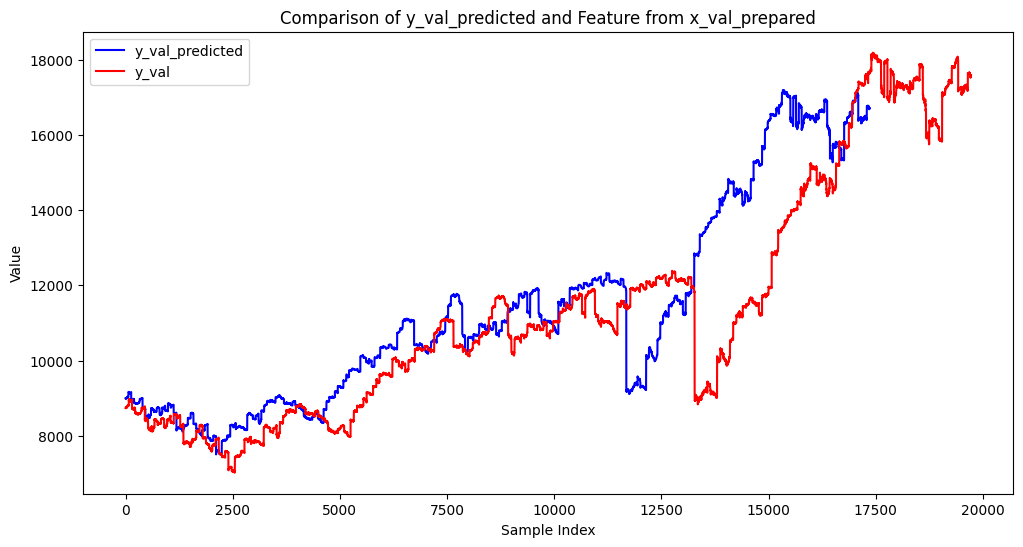

In [72]:
# Create the plot
plt.figure(figsize=(12, 6))

# Plot y_val_predicted
plt.plot(y_val_predicted, color='blue', label='y_val_predicted')

# Plot feature from x_val_prepared
plt.plot(y_val, color='red', label='y_val')

# Add labels and legend
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Comparison of y_val_predicted and Feature from x_val_prepared')
plt.legend()

# Show plot
plt.show()

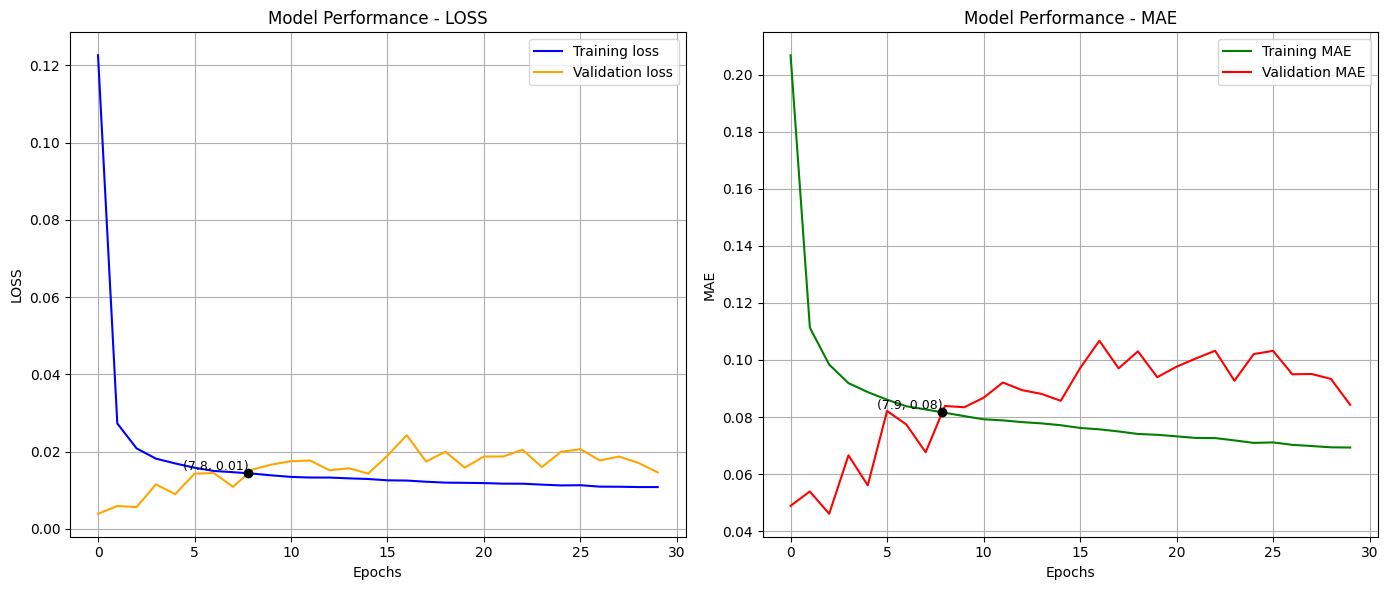

In [78]:
plot_errors(train_loss, val_loss, train_mae, val_mae , title_prefix='Model Performance')